In [1]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader

from gpolnel.problems.inductive_programming import SML
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GeneticAlgorithm
from gpolnel.operators.initializers import grow, prm_grow, ERC
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn
from gpolnel.operators.selectors import prm_tournament, roulette_wheel, rank_selection
from gpolnel.utils.inductive_programming import _execute_tree
seed=1
#_evaluate_individual_ffunction

In [2]:
##to do
#crossover
#random search
#exercises

In [3]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'cpu'

In [4]:
X_train = torch.tensor(pd.read_csv('datamart/X_train_clipped_scaled.csv').values)
X_test = torch.tensor(pd.read_csv('datamart/X_test_clipped_scaled.csv').values)
y_train = torch.tensor(pd.read_csv('datamart/y_lactose_train.csv')['lactose_percent'].values)
y_test = torch.tensor(pd.read_csv('datamart/y_lactose_test.csv')['lactose_percent'].values)

In [5]:
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1
total_batches = 1
batch_size = X_train.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))

print('Train:\t{}\nVal:\t{}\nTest:\t{}'.format(X_train.shape[0], X_test.shape[0], X_test.shape[0]))
print('Total:\t{}'.format(X_train.shape[0] + X_test.shape[0] + X_test.shape[0]))

# Creates training and validatation data sets
ds_train = TensorDataset(X_train, y_train)
ds_val = TensorDataset(X_test, y_test)

# Creates training and test data loaders
dl_train = DataLoader(ds_train, batch_size, shuffle)
dl_val = DataLoader(ds_val, batch_size, shuffle)

Batch size: 226
Total batches: 1

Train:	226
Val:	98
Test:	98
Total:	422


In [6]:
fset = [function_map['add'],  function_map['mul'], function_map['div'],function_map['sub']]#function_map['sub'],

sspace_sml = {
    'n_dims': X_train.shape[1],
    'function_set': fset, 'constant_set': ERC(-5., 5.),
    'p_constants': 0.1,
    'max_init_depth': 3,
    'max_depth': 5, 
    'n_batches': total_batches,
    'device': device
}


In [7]:
pi_sml = SML(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'),
    dl_train=dl_train, dl_test=dl_val,  # For the algorithm, the unseen is our validation!
    n_jobs=8
)


In [8]:
ps = 226
selection_pressure = .1
mutation_prob = .7
xo_prob = .9
has_elitism = True
allow_reproduction = False

mheuristic = GeneticAlgorithm(
    pi=pi_sml,
    initializer=grow,
    selector=prm_tournament(pressure=selection_pressure),  #prm_tournament(pressure=selection_pressure)
    crossover=swap_xo,
    mutator=prm_subtree_mtn(initializer=prm_grow(sspace_sml)),
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,  # False = or xo or mutation
    device=device,
    seed=seed
)

In [9]:
mheuristic._initialize()

In [10]:
print(mheuristic.pop)

0)	[mul, div, sub, 6, tensor(-4.7165), 0, 3] (fit: tensor(8.8911))
1)	[add, add, 0, 6, mul, 8, 10] (fit: tensor(5.2662))
2)	[mul, 6, mul, 5, 10] (fit: tensor(4.9594))
3)	[mul, 7, 0] (fit: tensor(5.3177))
4)	[sub, 2, 11] (fit: tensor(5.1042))
5)	[div, 1, 6] (fit: tensor(39.7989))
6)	[div, sub, 9, 2, add, 8, 5] (fit: tensor(8.3483))
7)	[div, 9, sub, 8, 0] (fit: tensor(5.0974))
8)	[sub, sub, 6, tensor(0.4011), 0] (fit: tensor(5.5124))
9)	[mul, mul, div, 10, tensor(-4.8331), div, 9, 1, mul, 2, 4] (fit: tensor(6.7841))
10)	[sub, 1, div, 3, 11] (fit: tensor(23.2750))
11)	[mul, 0, add, 11, sub, 3, 10] (fit: tensor(4.2667))
12)	[add, 6, div, 0, tensor(-4.2355)] (fit: tensor(5.0066))
13)	[div, sub, 8, mul, 11, 5, mul, 7, sub, 0, 6] (fit: tensor(37.9517))
14)	[div, 5, 3] (fit: tensor(48.5670))
15)	[div, sub, 10, 8, add, add, 8, 5, 5] (fit: tensor(6.8058))
16)	[add, sub, 1, tensor(-4.2681), mul, 9, tensor(0.5027)] (fit: tensor(1.2891))
17)	[add, 9, sub, 0, tensor(1.7041)] (fit: tensor(6.7810))
18

In [11]:
print(mheuristic.pop.individuals[0].repr_)

[mul, div, sub, 6, tensor(-4.7165), 0, 3]


In [12]:
mheuristic.pop.individuals[0].printTree()

mul( div( sub( x_6, -4.7165 ) x_0 ) x_3 )


In [13]:
feature_names = pd.read_csv('datamart/X_train_clipped_scaled.csv').columns
mheuristic.pop.individuals[0].printTree(feature_names=feature_names)

mul( div( sub( milkings_day, -4.7165 ) lactation ) rumination_min_day )


In [14]:
print(f'\nGP population: {mheuristic.pop.__class__} ({len(mheuristic.pop)} individuals)')

print(f'\nPoppulation fitness {mheuristic.pop.fit[:3]}...')
print(f'Poppulation valid {mheuristic.pop.valid[:3]}...\n')

for i in range(3):
    print(f'Individual {i}: {mheuristic.pop.individuals[i].repr_}, fitness {mheuristic.pop.individuals[i].fit}')

print(f'\nGP best individual {mheuristic.best_sol.printTree(out="string")}, fitness {mheuristic.best_sol.fit}\n\n')



GP population: <class 'gpolnel.utils.population.PopulationTree'> (226 individuals)

Poppulation fitness tensor([8.8911, 5.2662, 4.9594])...
Poppulation valid [True, True, True]...

Individual 0: [mul, div, sub, 6, tensor(-4.7165), 0, 3], fitness 8.891142845153809
Individual 1: [add, add, 0, 6, mul, 8, 10], fitness 5.266204833984375
Individual 2: [mul, 6, mul, 5, 10], fitness 4.959446907043457

GP best individual add( 4.7747, x_11 ), fitness 1.0133055448532104




In [15]:
# Log settings
file_dir = './log/'
file_name = 'intro.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

# Learning
n_iter = 3000

mheuristic.solve(
    n_iter,
    verbose=3, log=3, log_path=log_path,
    test_elite=True
)

-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Length   Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 3        1.13076          1.06948               0.114 | -1                             -1
1          | 5        0.532116         0.520087              0.161 | -1                             -1
2          | 9        0.496285         0.540506              0.192 | -1                             -1
3          | 1        0.476284         0.487725              0.166 | -1                             -1
4          | 11       0.0686963        0.0714806             0.152 | 

KeyboardInterrupt: 

In [ ]:
print(f'\nGP best individual {mheuristic.best_sol.printTree(feature_names=feature_names)}, fitness {mheuristic.best_sol.fit}\n\n')
from sklearn.metrics import root_mean_squared_error
xt = pd.read_csv('datamart/X_test.csv')
yt = pd.read_csv('datamart/y_lactose_test.csv')
xt['y_pred'] = xt['forage_kg_day']
xt['y_true'] = yt['lactose_percent']
# xt['y_pred'] = ((0.9399 + xt['forage_kg_day']) / (-0.53 + xt['milkings_day'])) + (0.9399 * (0.8875 * xt['milkings_day']))
xt['y_true'] = yt['lactose_percent']
print(root_mean_squared_error(xt['y_true'], xt['y_pred']))
pi_sml._evaluate_sol(mheuristic.best_sol, dl_val)

add( 4.4174, div( 4.4174, add( 4.4174, add( 4.4174, div( 4.4174, 4.4174 ) ) ) ) )

GP best individual None, fitness 0.0686962828040123


0.6725839806730843


tensor(0.0715, dtype=torch.float64)

In [ ]:
xt['forage_kg_day']

0     4.943943
1     4.934455
2     5.126063
3     5.467770
4     4.849077
        ...   
93    5.400906
94    4.251472
95    4.948162
96    5.099505
97    5.179536
Name: forage_kg_day, Length: 98, dtype: float64

In [ ]:
# Open log file
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Val fitness history
history_val_fits = [float(row[8].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [int(row[6]) for row in rows]

# Runtime
history_timing = [float(row[5]) for row in rows]


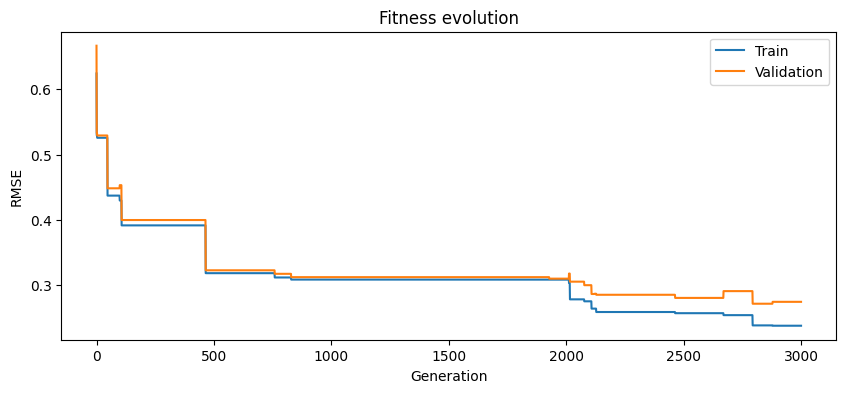

Best solution RMSE fitness: 0.24 train, 0.27 validation.



In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_fits, label='Train')
plt.plot(history_val_fits, label='Validation')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} validation.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))


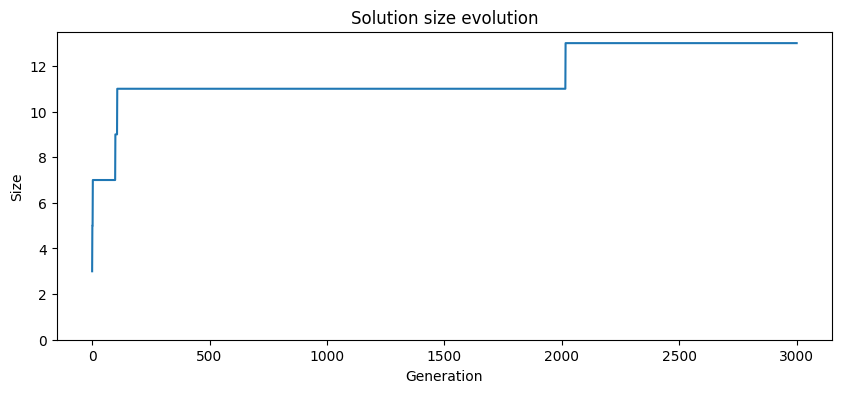

In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()


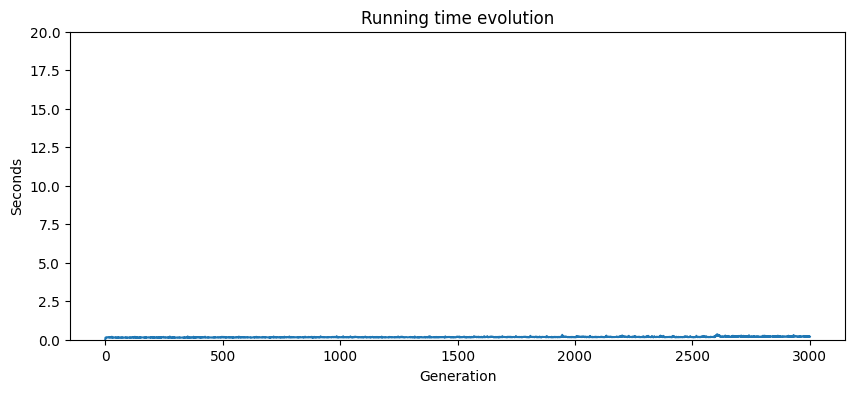

Total time: 8.60 minutes.



In [ ]:
plt.figure(figsize=(10, 4))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0, top=20)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))


In [ ]:
pi_sml._evaluate_sol(mheuristic.best_sol, dl_val)

tensor(0.2744, dtype=torch.float64)

In [ ]:
mheuristic.pop.__repr__()

'<gpolnel.utils.population.PopulationTree object at 0x000001CAE23C2390>'

In [ ]:
mheuristic._evaluate_sol(mheuristic.best_sol.__repr__, dl_val)


AttributeError: 'GeneticAlgorithm' object has no attribute '_evaluate_sol'

In [ ]:
mheuristic.best_sol.printTree(feature_names=feature_names)

add( forage_kg_day, 0.0148 )


In [ ]:
mheuristic.best_sol.get_all_subtrees()[0]

[]

In [ ]:
_execute_tree(mheuristic.best_sol.get_all_subtrees(), dl_val)

IndexError: list index out of range

In [ ]:
mheuristic.__repr__